# ECS8 утилиты для работы с БД MS SQL
1. Выгрузка *Mimics* и *Faceplates*, а так же ремонт мнемосхем;
1. Выгрузка текстовых записей и сохранение в CSV, загрузка обратно;
1. В последующем что то добавится еще...


## Настройка MS SQL

Для доступа скрипта к СУБД нужно:
1. Включить аутентификацию на SQL сервере, для этого:
    * подключится через **SQL Server Managment Studio** к **CУБД**;
    * **ПКМ** по серверу в дереве на панеле справа -> **properties**;
    * в окне вкладка **Security** -> установить радиокнопку **SQL Server and Windows Authentication**.
    
        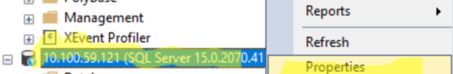

        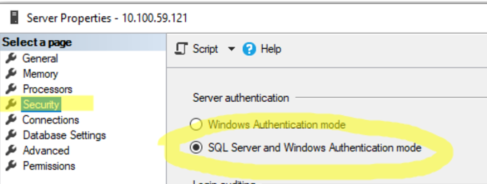

2. Добавить пользователя СУБД:
    * в дереве на панеле справа -> **Security** -> **Logins** -> **ПКМ** -> **New Logins**;
    * создайте пользователя, наделите правами для доступа к требуемым таблицам (**Sever Roles** -> ~~**sysadmin**~~).
        
        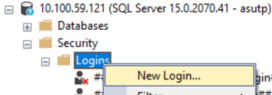
        
        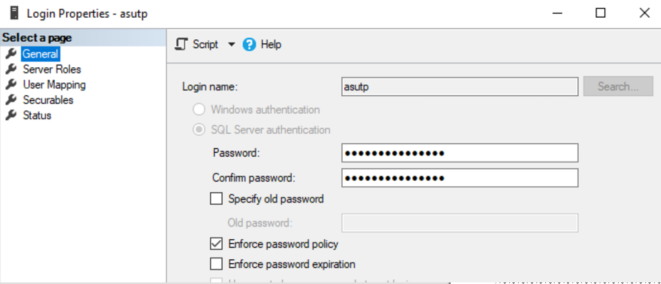


    

## Выгрузка из ECS SQL DB фейсплейтов и ремонт мнемосхем
### Выгрузка FP
Тут и так всё понятно, смотри видео ниже.

### Ремонт мнемосхем  ECS с "красной полосой"
#### Описание проблемы
Некоторые мнемосхемы ECS после восстановления бакапа или solution переданных FLS, 
не отображаются на скаде - не открываются на редактирование.

В матрице ECS такие экраны показаны с красной полосой. 

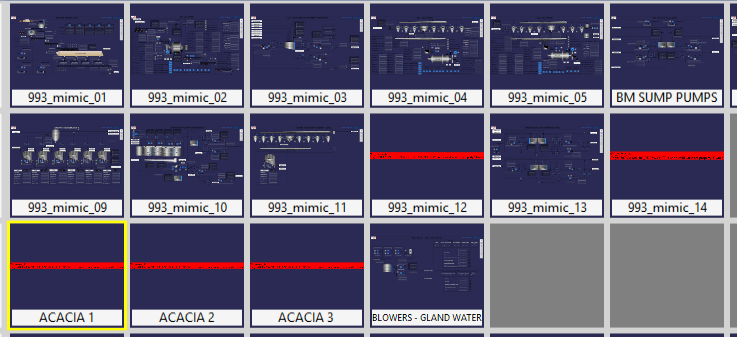

Если  открыть такой мимик в вювере то на красном фоне будет сообщение:

`"Mimic: 993_mimic_15
'Tag:::2040IL200A01RBOOL_38%%%BC:::TTTTF%%%CC:::TF' is not a valid value for property 'Owner'.
"`


#### Причины проблемы
Если в XML файле мнемосхемы есть тег с атрибутом: **FlsBase:Info.Owner** и он содержит сылку на несуществующую точку скады.

Пример:

`{<Canvas Canvas.Left="931.875" Canvas.Top="55.625" FlsBase:Info.DataParent="{Binding Parent}" FlsBase:Info.Owner="Tag:::2080TN450A01%%%BC:::TTTTF%%%CC:::FT" Height="26.25" IsEnabled="True" RenderTransform="0.518706044724204,0,0,0.664428231794079,1.23839054157131,28.8733485810588" Tag="HmiGroup" Width="426.25">}`
> [!INFO]
> Если другие атрибуты ссылаются на несуществующие точки скады то данной проблемы не наблюдается.

#### Решение проблемы
1. Создать недостающую точку скады. Но тут не всё просто, атрибут содержит шаблон.. во общем не очень понятно какая точка должна быть.. тема для будущих исследований.
1. Удалить у тэга атрибут  **FlsBase:Info.Owner ** вместе со значением и загрузить xaml файл обратно в ECS через меню **Import** редактора окон или другим способом.
2й способ лечения реализует скрипт ниже.


In [1]:
%%HTML
<h2>Демонстрация работы</h2>
<h3>Выгрузка Mimics и Faceplates</h3>
<video width="640"   controls>
  <source src="./resources/video/get_fp.mp4" type="video/mp4">
</video>
<h3>Починка мнемосхем с "красной строкой"</h3>
<video width="640"   controls>
  <source src="./resources/video/mimic_fixer.mp4" type="video/mp4">
</video>
<h3>Выгрузка текстовых записей и сохранение в CSV, загрузка обратно</h3>
<video width="640"   controls>
  <source src="./resources/video/get_put_txt.mp4" type="video/mp4">
</video>

### Общий код

In [2]:
# Импорт библиотек:
import logging
import re
import time
from datetime import datetime
from pathlib import Path

import ipywidgets as wg  # элементы управления для jupyter
import pandas as pd
import pyodbc  # odbc для python
from bs4 import BeautifulSoup
from IPython.display import FileLink, FileLinks
from ipywidgets import Layout, interact, interact_manual

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [3]:
# Константы и инициализация
_PRG_DIR = Path("./").absolute()
_MIM_DIR = Path("./ECS8_SQL/mim_and_fp/")
logger = logging.getLogger()
_SERVERS = (
    ("Тестовый 10.100.59.149", "10.100.59.149"),
    ("ECS 10.100.59.121", "10.100.59.121"),
    ("Тестовый2 10.100.59.126", "10.100.59.126"),
    ("Тестовый2 10.100.59.152", "10.100.59.152"),
)
USER = "asutp"
PASSWORD = "master"
DATABASE = "Fls.Core.Hmi"

In [4]:
class ECS8DBHelper(object):
    """Базовый класс для работы с БД ECS"""

    def __init__(
        self,
        server="10.100.59.20\SQL_TEST_SRV",
        database="",
        user="asutp",
        password="master",
    ):
        self.server = server
        self.user = user
        self.password = password
        self.database = database
        self._connect()

    def _connect(self):
        try:
            self.cnxn = pyodbc.connect(
                f"""DRIVER={{ODBC Driver 18 for SQL Server}};ENCRYPT=no;\
                SERVER={self.server};DATABASE={self.database};UID={self.user};PWD={self.password}"""
            )
            self.cursor = self.cnxn.cursor()
            print("Connections to self.server.... OK")
        except ConnectionError as e:
            print("Connections to self.server.... Fail")
            logger.error(e)

    def __del__(self):
        self._close()

    def _close(self):
        self.cnxn.close()

    def _ex_sql_ins_upd(self, sql_req):
        """Вставка или обновления записей в таблице"""
        count = self.cursor.execute(sql_req).rowcount
        # self.cursor.execute(sql_req)
        self.cnxn.commit()
        return count

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_59052/2468711374.py:6: SyntaxWarning: invalid escape sequence '\S'
  server="10.100.59.20\SQL_TEST_SRV",


### Код выгрузки экранов и фейсплейтов

In [5]:
class ECS8Mimics(ECS8DBHelper):
    """Выгрузка мимиков и файсплейтов из БД"""

    def __init__(
        self,
        server="10.100.59.20\SQL_TEST_SRV",
        user="asutp",
        password="master",
    ):
        super().__init__(server, "Fls.Core.Hmi", user, password)

    # Получение списка имён Faceplates
    def _get_scr_names(self, typ="fp") -> list:
        if typ == "fp":
            sql_req = """SELECT  *  FROM [dbo].[Faceplates];"""
        else:
            sql_req = """SELECT  *  FROM [dbo].[Mimics];"""
        self.cursor.execute(sql_req)
        mims = []
        for row in self.cursor:
            mims.append(row[1])
            mims.sort()
        return mims

    # Получение указанного экрана
    def _get_scr(self, scr_name, typ="fp") -> list:
        if typ == "fp":
            sql_req = f"""
                SELECT * FROM [dbo].[Faceplates]
                WHERE [Designation] = '{scr_name}'
                """
        else:
            sql_req = f"""
                SELECT * FROM [dbo].[Mimics]
                WHERE [Designation] = '{scr_name}'
                """
        self.cursor.execute(sql_req)
        return self.cursor.fetchone()

    def _update_scrn(self, registrid, text) -> bool:
        """обновление экрана"""
        sql_req = f"""UPDATE [dbo].[ConfigValue]
                     SET [LanguageText] = N'{text}'
                     WHERE [RegisterId] = '{registrid}'"""
        return True if (self._ex_sql_ins_upd(sql_req)) > 0 else False

    # Получение списка имён Faceplates
    def get_fp_names(self) -> list:
        return self._get_scr_names("fp")

    # Получение списка имён мнемосхем
    def get_mim_names(self) -> list:
        return self._get_scr_names("mim")

    # Получение указанного Faceplate
    def get_fp(self, fp_name) -> list:
        return self._get_scr(mim_name, "fp")

    # Получение указанного Mimic
    def get_mim(self, mim_name) -> list:
        return self._get_scr(mim_name, "mim")

    def get_mim_as_xml(self, mim_name) -> str:
        scr = self._get_scr(mim_name, "mim")
        mim_xml = scr[4].decode("utf-8")
        return mim_xml

    # сохранение Faceplate как файла
    def save_to_file(self, scr_name, typ="fp"):
        scr = self._get_scr(scr_name, typ)
        with open(_PRG_DIR / "mim_and_fp" / scr[1], mode="wb") as f:
            f.write(scr[4])
            f.close

    def _update_mimic(self, scr_name, mim_xml) -> bool:
        """обновление мнемосхемы в базе"""

        str_xml = mim_xml.encode("utf-8")
        bin_xml = pyodbc.Binary(str_xml)
        sql_req = f"""
        UPDATE [dbo].[Mimics]  SET [Blob]  = ?, [Modified] = ?  WHERE [Designation] = ?
        """
        cur_datatime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        # self.cursor.execute(sql_req, (bin_xml, cur_datatime , scr_name))
        count = self.cursor.execute(sql_req, (bin_xml, cur_datatime, scr_name)).rowcount
        self.cnxn.commit()

        return True if count > 0 else False

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_59052/190892027.py:6: SyntaxWarning: invalid escape sequence '\S'
  server="10.100.59.20\SQL_TEST_SRV",


In [6]:
# Виджеты для Jupyter
# Выбор сервера
w_srv = wg.Dropdown(
    options=_SERVERS,
    description="SQL сервер:",
)

w_fps = wg.Dropdown(options="Undef", description="Faceplates:")

w_mims = wg.Dropdown(options="Undef", description="Mimics:")


w_usr = wg.Text(
    value=USER, placeholder="Type something", description="User:", disabled=False
)

w_pswd = wg.Text(
    value=PASSWORD,
    placeholder="Type something",
    description="Password:",
    disabled=False,
)
w_btn_cnct = wg.Button(
    description="Connect",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_btn_save_fp = wg.Button(
    description="Save FP",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_btn_save_mim = wg.Button(
    description="Save Mimic",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_html1 = wg.HTML(
    value="""<H1>Выгрузка Мнемосхем и Файсплейтов ECS8, починка экранов с "красной строкой"</H1>
    """,
    placeholder="",
    description="",
)
w_html2 = wg.HTML(
    value="""<H2>Выберите файл для выгрузки или починки:</H2>\
    <p>Файлы сохраняются в папку <b>mim_and_fp</b>, см. панель слева.</p>
    <p>Способ починки мимика описан в начале документа.</p>
    """,
    placeholder="",
    description="",
)

w_output = wg.Output()
w_output2 = wg.Output()

# Fix mimic
w_btn_get_mim = wg.Button(
    description="Get Mimic For Fix",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)

w_btn_fix_mim = wg.Button(
    description="Fix Mimic & Upload",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_output_xml_log = wg.Output()
w_output_xml_table = wg.Output()

box_layout = Layout(
    display="flex", flex_flow="row", align_items="flex-start", width="auto"
)

In [7]:
MIM_SOUP = BeautifulSoup()
CHEKBOXS_FIX = []

In [8]:
def connect_to_hmi_db(b):
    global ECS_MIM_DB
    ECS_MIM_DB = ECS8Mimics(server=w_srv.value, user=w_usr.value, password=w_pswd.value)
    box_layout = Layout(
        display="flex", flex_flow="row", align_items="flex-end", width="100%"
    )
    w_fps.options = ECS_MIM_DB.get_fp_names()
    w_mims.options = ECS_MIM_DB.get_mim_names()
    w_output.clear_output()
    row1 = wg.HBox([w_fps, w_btn_save_fp])
    row1.layout = box_layout
    row2 = wg.HBox([w_mims, w_btn_save_mim, w_btn_get_mim])
    vbx = wg.VBox([row1, row2])
    with w_output:
        print(f"Conections to {w_srv.value}... OK\n")
        display(w_html2, vbx, w_output2)


def save_fp(b):
    ECS_MIM_DB.save_to_file(w_fps.value, "fp")
    # file = FileLink(_MIM_DIR / w_fps.value)
    w_output2.clear_output()
    with w_output2:
        print(f"File saved to {_MIM_DIR / w_fps.value}")
        # display(file)


def save_mim(b):
    ECS_MIM_DB.save_to_file(w_mims.value, "mim")
    # file = FileLink(_MIM_DIR / w_mims.value)
    w_output2.clear_output()
    with w_output2:
        print(f"File saved to {_MIM_DIR / w_mims.value}")
        # display(file)


@w_output_xml_table.capture()
def get_mimic_for_fix(b):
    """Ищет в выбранном мимике тэги с атрибутом FlsBase:Info.Owner и показывает"""
    global MIM_SOUP  # mim xml в прекрастном мыле
    global TRBL_TAGS  # тэги с проблемным атрибутом

    mim_xml = ECS_MIM_DB.get_mim_as_xml(w_mims.value)
    MIM_SOUP = BeautifulSoup(mim_xml, "xml")
    TRBL_TAGS = MIM_SOUP.findAll(attrs={"FlsBase:Info.Owner": re.compile(r".+")})
    w_output2.clear_output()
    w_output_xml_table.clear_output()
    CHEKBOXS_FIX.clear()

    for tag in TRBL_TAGS:
        w_chekbox = wg.Checkbox(indent=False)
        w_chekbox.layout = box_layout
        # display(wg.HBox([chb, wg.HTML(value=str(tag)]))
        row = wg.HBox(
            [
                w_chekbox,
                wg.Textarea(value=str(tag), disabled=True),
                wg.HTML(
                    value=f" FlsBase:Info.Owner:<br/> <b>{tag.attrs['FlsBase:Info.Owner']}</b>"
                ),
            ]
        )
        row.layout = box_layout
        display(
            row,
        )
        CHEKBOXS_FIX.append(w_chekbox)

    print(f"На {w_mims.value} проблемных тегов: {len(TRBL_TAGS)}")

    display(w_btn_fix_mim)


@w_output_xml_log.capture()
def fix_mimic(b):
    """Удаление атрибута FlsBase:Info.Owner в отмеченных тегах"""
    w_output_xml_log.clear_output()
    i = 0
    qnt_del = 0
    for w_chekbox in CHEKBOXS_FIX:
        if w_chekbox.value:
            del TRBL_TAGS[i]["FlsBase:Info.Owner"]
            qnt_del += 1
        i += 1

    if qnt_del > 0:  # Если есть отмеченные chkbox
        var = ECS_MIM_DB._update_mimic(w_mims.value, str(MIM_SOUP))
    print(f"Кол-во удаленных атрибутов: {qnt_del}")

    get_mimic_for_fix("b")


# связывание кнопок с обработчиками
w_btn_cnct.on_click(connect_to_hmi_db)
w_btn_save_fp.on_click(save_fp)
w_btn_save_mim.on_click(save_mim)

w_btn_get_mim.on_click(get_mimic_for_fix)
w_btn_fix_mim.on_click(fix_mimic)

## Выгрузка мнемосхем и FP, починка

In [9]:
# Показать виджеты
display(
    w_html1,
    w_srv,
    w_usr,
    w_pswd,
    w_btn_cnct,
    w_output,
    w_output_xml_table,
    w_output_xml_log,
)

HTML(value='<H1>Выгрузка Мнемосхем и Файсплейтов ECS8, починка экранов с "красной строкой"</H1>\n    ', placeh…

Dropdown(description='SQL сервер:', options=(('Тестовый 10.100.59.149', '10.100.59.149'), ('ECS 10.100.59.121'…

Text(value='asutp', description='User:', placeholder='Type something')

Text(value='master', description='Password:', placeholder='Type something')

Button(description='Connect', icon='check', style=ButtonStyle(), tooltip='Click me')

Output()

Output()

Output()

## Код: Выборка, выгрузка и загрузка текстовых сообщений


In [14]:
class ECS8Texts(ECS8DBHelper):
    """Работа с текстовыми записями в SQL БД EC8"""

    def __init__(
        self,
        server="10.100.59.20\SQL_TEST_SRV",
        user="asutp",
        password="master",
    ):
        database = "Fls.Core.Lan"
        super().__init__(server, database, user, password)

    def _ex_sql_select(self, sql_req, head_on=False) -> list:
        """Выборка из таблицы"""
        self.cursor.execute(sql_req)
        columns = [column[0] for column in self.cursor.description]
        results = []
        if head_on:
            results.append(columns)
        results += [list(row) for row in self.cursor.fetchall()]
        # results.sort()
        return results

    def get_txt_records(self, sub_prod=None, fnd_txt="%", head_on=True):
        sql_req = """SELECT 
        [dbo].[Register].[RegisterId],[Caption]
        ,[DefaultText]
        ,[Fls.Core.Lan].[dbo].[ConfigValue].[LanguageText]
        ,[Fls.Core.Lan].[dbo].[SubProduct].SubProductName
        FROM [Fls.Core.Lan].[dbo].[Register]
        LEFT  JOIN [Fls.Core.Lan].[dbo].[ConfigValue] ON [Fls.Core.Lan].[dbo].[Register].[RegisterId] = [Fls.Core.Lan].[dbo].[ConfigValue].[RegisterId]
        LEFT JOIN [Fls.Core.Lan].[dbo].[SubProduct] ON [Fls.Core.Lan].[dbo].[Register].[SubProductId] = [Fls.Core.Lan].[dbo].[SubProduct].[SubProductId]
        """
        sql_cond1 = f""" WHERE ([Fls.Core.Lan].[dbo].[Register].[Caption] LIKE '%{fnd_txt}%'
                         OR [Fls.Core.Lan].[dbo].[ConfigValue].[LanguageText] LIKE N'%{fnd_txt}%')"""
        sql_req += sql_cond1
        if sub_prod != "all":
            sql_req += (
                f"AND [Fls.Core.Lan].[dbo].[Register].[SubProductId] = '{sub_prod}'"
            )

        return self._ex_sql_select(sql_req, head_on=True)

    def get_subproducts(self) -> list:
        sql_req = """
            SELECT [SubProductName]
          ,[SubProductId]
          FROM [dbo].[SubProduct]
        """
        return self._ex_sql_select(sql_req)

    def find_caption(self, caption):
        pass

    def get_txt_record(self, tag_only=False):
        pass

    def set_text_records(records):
        pass

    def check_rus_record(self, registrid) -> bool:
        """Проверка наличия записи с индефикаторм registrid в таблице ConfigValue"""
        sql_req = f"""SELECT * FROM [dbo].[ConfigValue]
        WHERE [RegisterId] = '{registrid}'"""
        return True if (self._ex_sql_select(sql_req)) else False

    def _update_rus_record(self, registrid, text) -> bool:
        """обновление записи в таблице ConfigValue"""
        sql_req = f"""UPDATE [dbo].[ConfigValue]
                     SET [LanguageText] = N'{text}'
                     WHERE [RegisterId] = '{registrid}'"""
        return True if (self._ex_sql_ins_upd(sql_req)) > 0 else False

    def _insert_rus_record(self, registrid, text) -> bool:
        """вставка записи в таблицу ConfigValue"""
        sql_req = f"""
        INSERT INTO [dbo].[ConfigValue]
           ([dbo].[ConfigValue].[RegisterId]
           ,[LocalCultureId]
           ,[LanguageText])
         VALUES
           ('{registrid}'
           ,1049
           ,N'{text}')"""
        return True if (self._ex_sql_ins_upd(sql_req)) > 0 else False

    def _del_rus_record(self, registrid) -> bool:
        """Удаление записи из таблицы ConfigValue"""
        sql_req = (
            f"""DELETE FROM [dbo].[ConfigValue] WHERE [RegisterId] = {registrid}"""
        )
        return True if (self._ex_sql_ins_upd(sql_req)) > 0 else False

    def update_rus_record(self, registrid, text):
        """"""
        res = ""
        # Если запись есть то обновление иначе вставка в таблицу
        if self.check_rus_record(registrid):
            self._update_rus_record(registrid, text)
            res = "update"
        else:
            self._insert_rus_record(registrid, text)
            res = "insert"
        return res

    @staticmethod
    def update_progress_bar(w_prog_bar, value=50, max_val=100):
        """Обновляет виджет прогресбар"""
        # w_prog_bar.max = max_val
        w_prog_bar.value = value

    @staticmethod
    def init_progress_bar(w_prog_bar, value=50, max_val=100, min_val=0):
        """Инициализирует виджет прогресбар"""
        w_prog_bar.max = max_val
        w_prog_bar.max = min_val
        w_prog_bar.value = value

    def update_rus_records(self, df, w_prog_bar=None) -> dict:
        """Полученый Dataframe записывает в SQL базу ECS8"""
        start_time = time.perf_counter()
        result = {"total": 0, "insert": 0, "update": 0, "time_ex": 0}
        cnt = 0
        # len_df  = len(df)

        if type(w_prog_bar) is wg.IntProgress:
            feel_prgbar = True
            w_prog_bar.max = len(df)
            proc_1 = len(df) / 100
        else:
            feel_prgbar = False

        for (
            _,
            registerid,
            caption,
            defaultText,
            languagetext,
            subproductname,
        ) in df.itertuples():
            res = self.update_rus_record(registerid, languagetext)
            result[res] += 1
            result["total"] += 1
            # если передан прогресбар то заполняем по мере обработки
            if feel_prgbar:
                cnt += 1
                if cnt > proc_1:
                    cnt = 0
                    self.update_progress_bar(w_prog_bar, result["total"])

        result["time_ex"] = {time.perf_counter() - start_time}
        return result

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_59052/623918683.py:6: SyntaxWarning: invalid escape sequence '\S'
  server="10.100.59.20\SQL_TEST_SRV",


In [11]:
# Jupyter  widgets
w_dd_sprod = wg.Dropdown(options="", description="SubProd:")
w_btn_get_table = wg.Button(
    description="Get From ECS",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_btn_cnct2 = wg.Button(
    description="Connect",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_btn_save_csv = wg.Button(
    description="Save CSV",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_btn_load_csv = wg.Button(
    description="Load CSV",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_btn_send_to_srv = wg.Button(
    description="Put To ECS",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",  # (FontAwesome names without the `fa-` prefix)
)
w_t_caption = wg.Text(
    value="", placeholder="Type something", description="Caption:", disabled=False
)
w_t_find_text = wg.Text(
    value="", placeholder="Type something", description="Поиск:", disabled=False
)
w_prg_ldtosrv = wg.IntProgress(
    value=0,
    min=0,
    max=100,
    description="Put to ECS:",
    bar_style="",  # 'success', 'info', 'warning', 'danger' or ''
    style={"bar_color": "maroon"},
    orientation="horizontal",
)


w_htm_txt_head = wg.HTML(value="""<H1>ECS8 работа с текстом:</H1>""")
w_htm_txt_db = wg.HTML(value="""<H2>Подключение к ДБ:</H2>""")
w_htm_txt_df = wg.HTML(value="""<H2>Получение записей и сохранение в CSV:</H2>""")
w_htm_txt_load_cvs = wg.HTML(value="""<H2>Загрузка CSV:</H2>""")

w_output_filter = wg.Output()
w_output_table = wg.Output()
w_output_table_status = wg.Output()
w_output_table_ed = wg.Output()

In [12]:
def connect_to_lan_db(b):
    """Подключение ECS SQL Server"""
    global ECS_LAN_DB
    ECS_LAN_DB = ECS8Texts(server=w_srv.value, user=w_usr.value, password=w_pswd.value)
    w_dd_sprod.options = [["Всё", "all"]] + ECS_LAN_DB.get_subproducts()
    w_output_filter.clear_output()
    w_output_table.clear_output()
    with w_output_filter:
        print(f"Conections to {w_srv.value}... OK\n")
        # display( wg.HBox([w_dd_sprod, w_btn_get_table]) ,w_t_find_text)
        display(w_htm_txt_df, w_dd_sprod, wg.HBox([w_t_find_text, w_btn_get_table]))


def get_table(b):
    """Получение данных с ECS SQL Server"""
    global DF
    DF = pd.DataFrame(ECS_LAN_DB.get_txt_records(w_dd_sprod.value, w_t_find_text.value))
    # 0 row to header
    new_header = DF.iloc[0]  # grab the first row for the header
    DF = DF[1:]  # take the data less the header row
    DF.columns = new_header  # set the header row as the df header
    w_output_table.clear_output()
    w_html = wg.HTML(value=f"Колличество записей: <b>{len(DF)}</b>")
    with w_output_table:
        display(
            w_html,
            DF,
            w_btn_save_csv,
            w_output_table_status,
            w_htm_txt_load_cvs,
            w_btn_load_csv,
        )


def save_csv(b):
    """Сохранение текстовых записей из базы в CSV"""
    w_output_table_status.clear_output()
    DF.to_csv("ecs8_text_records.csv", index=False)
    with w_output_table_status:
        print("Таблица сохранена в ./ecs8_text_records.csv")


def load_csv(b):
    """Загрузка локального CSV файла"""
    global DF2
    DF2 = pd.read_csv("./ecs8_text_records.csv")
    # Удаление пустых строк
    DF2 = DF2.dropna(how="all").reset_index(drop=True)
    w_output_table_ed.clear_output()
    with w_output_table_ed:
        display(DF2, w_btn_send_to_srv)


def send_table(b):
    """ "Отправка данных на ECS SQL Server"""
    with w_output_table_ed:
        display(w_prg_ldtosrv)
        result = ECS_LAN_DB.update_rus_records(DF2, w_prg_ldtosrv)
        display(
            wg.HTML(
                value=f"""Всего обработано: {result['total']}     Новых: {result['insert']}
             Обновлено: {result['update']}     Время загрузки: {result['time_ex']} сек."""
            )
        )


# связывание кнопок с функциями
w_btn_cnct2.on_click(connect_to_lan_db)
w_btn_get_table.on_click(get_table)
w_btn_save_csv.on_click(save_csv)
w_btn_load_csv.on_click(load_csv)
w_btn_send_to_srv.on_click(send_table)


# display(w_html3, wg.HBox([w_dd_sprod, w_btn_get_table]) ,w_t_find_text, w_output3)
# w_btn_load_csv, w_output_table_ed

## ECS8 работа с текстом:

In [13]:
# Показать виджеты
display(
    w_htm_txt_head,
    w_htm_txt_db,
    w_srv,
    w_usr,
    w_pswd,
    w_btn_cnct2,
    w_output_filter,
    w_output_table,
    w_output_table_ed,
)

HTML(value='<H1>ECS8 работа с текстом:</H1>')

HTML(value='<H2>Подключение к ДБ:</H2>')

Dropdown(description='SQL сервер:', options=(('Тестовый 10.100.59.149', '10.100.59.149'), ('ECS 10.100.59.121'…

Text(value='asutp', description='User:', placeholder='Type something')

Text(value='master', description='Password:', placeholder='Type something')

Button(description='Connect', icon='check', style=ButtonStyle(), tooltip='Click me')

Output()

Output()

Output()